# Some Data Processing Tools

In [1]:
import os 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import math

plt.rcParams.update({
    "figure.facecolor": (1,1,1,1),
    "axes.facecolor": (1,1,1,1),
    "savefig.facecolor": (1,1,1,1)
})

from matplotlib.ticker import ScalarFormatter

## File paths 

In [2]:
folder_path = os.path.join("..","Fall2024Data")
flash_data_raw = os.path.join(folder_path, "ASCEND_DATA_2024_11_25_19_13_57.csv")
data2 = os.path.join(folder_path, "DATA2.CSV")
data3 = os.path.join(folder_path, "DATA3.CSV")
data4 = os.path.join(folder_path, "DATA4.CSV")
geiger_data = os.path.join(folder_path, "RadiaCode Log.txt")
geiger_spectrum_xml = os.path.join(folder_path, "RadiaCode_ Spectrum.xml")

aprs_data_csv = os.path.join(folder_path, "aprsfi_KA7NSR-9_data.csv")

# create directory for processed files:
temp_folder = "F24Processed"
os.makedirs(temp_folder, exist_ok=True)

# folder to store graphs
graph_folder = "Graphs"
os.makedirs(graph_folder, exist_ok=True)

In [3]:
def parseHeader(header_field):
    header_field = int(header_field, 16)
    full_no_fail_header = [
      "Header,",
      "Millis,",

      "PCFTime, ", 
      # "DS3231Time,DS3231TempC,",
      "BMETemp(C),BMEPress(hPa),BMEHum(%),BMEGas(KOhms),BMEAlt(m),",    
      # "GeigerSensor(CPS),", 
      "INACurr(mA),INAVolt(mV),INAPow(mW),",                   
      "LSM9DS1 AccX, LSM9DS1 AccY, LSM9DS1 AccZ, LSM9DS1 GyroX, LSM9DS1 GyroY, LSM9DS1 GyroZ, LSM9DS1 MagX, LSM9DS1 MagY, LSM9DS1 MagZ,", 
      # "SHTHum(%), SHTTemp(C),",
      "PicoTemp(C),",
      #"WindADC,TempADC,", 
      "SGPTVOC(ppb),SGPeCO2(ppm),SGPTVOCBase(ppb),SGPeCO2Base(ppb),SGPH2,SGPEtha,",
      "BME280RelHum %,BME280Pres Pa,BME280Alt m,BME280TempC,DewPointC,",  
      "ENSAQI,ENSTVOC ppb,ENSECO2 ppm,",
      "UVA2(nm),UVB2(nm),UVC2(nm),",
      "UVA0(nm),UVB0(nm),UVC0(nm),",
      "ICM AccX,ICM AccY,ICM AccZ,ICM GyroX,ICM GyroY,ICM GyroZ,ICM MagX,ICM MagY,ICM MagZ,ICM TempC,",
      "MTK_Date,MTK_Lat,MTKLong,MTKSpeed,MTKAngle,MTKAlt,MTKSats,",
      " "  # final space for matching fsw?
    ]
    header_bin = bin(header_field)[2:]
    header_bin = header_bin[header_bin.find("1"):] # trim to first 1
    header = "Receive time, "
    for i in range(len(header_bin)): # add each from full header if 1
        if header_bin[i] == "1": header += full_no_fail_header[i]
    return header

## Getting Data

In [4]:
# get flash data
flash_data = os.path.join(temp_folder, "flash_data_header.csv")
with open(flash_data_raw, "r") as fin, open(flash_data, "w") as fout:
    finlist = list(fin)
    fout.write(parseHeader(finlist[0].split(",")[1]) + "\n")
    for line in finlist:
        if(line.split(",")[1] == " 3f82" and line.split(",")[3].find("2005") != -1):
            break
        if(line.split(",")[1] == " 3f82"):
            fout.write(line)

In [5]:
custom_na = pd._libs.parsers.STR_NA_VALUES
custom_na.add("-")
flash_df = pd.read_csv(flash_data, skipinitialspace=True, na_values=custom_na)

flash_df["Minutes(millis)"] = [i / 1000 / 60 for i in flash_df["Millis"]]
print(list(flash_df.columns))

['Receive time', 'Header', 'Millis', 'PCFTime', 'BMETemp(C)', 'BMEPress(hPa)', 'BMEHum(%)', 'BMEGas(KOhms)', 'BMEAlt(m)', 'INACurr(mA)', 'INAVolt(mV)', 'INAPow(mW)', 'LSM9DS1 AccX', 'LSM9DS1 AccY', 'LSM9DS1 AccZ', 'LSM9DS1 GyroX', 'LSM9DS1 GyroY', 'LSM9DS1 GyroZ', 'LSM9DS1 MagX', 'LSM9DS1 MagY', 'LSM9DS1 MagZ', 'PicoTemp(C)', 'ICM AccX', 'ICM AccY', 'ICM AccZ', 'ICM GyroX', 'ICM GyroY', 'ICM GyroZ', 'ICM MagX', 'ICM MagY', 'ICM MagZ', 'ICM TempC', 'Unnamed: 32', 'Minutes(millis)']


## General Functions
The idea is to have an array of functions that can be applied to a plot to add information to it

### Plot with Pressure as the X-axis

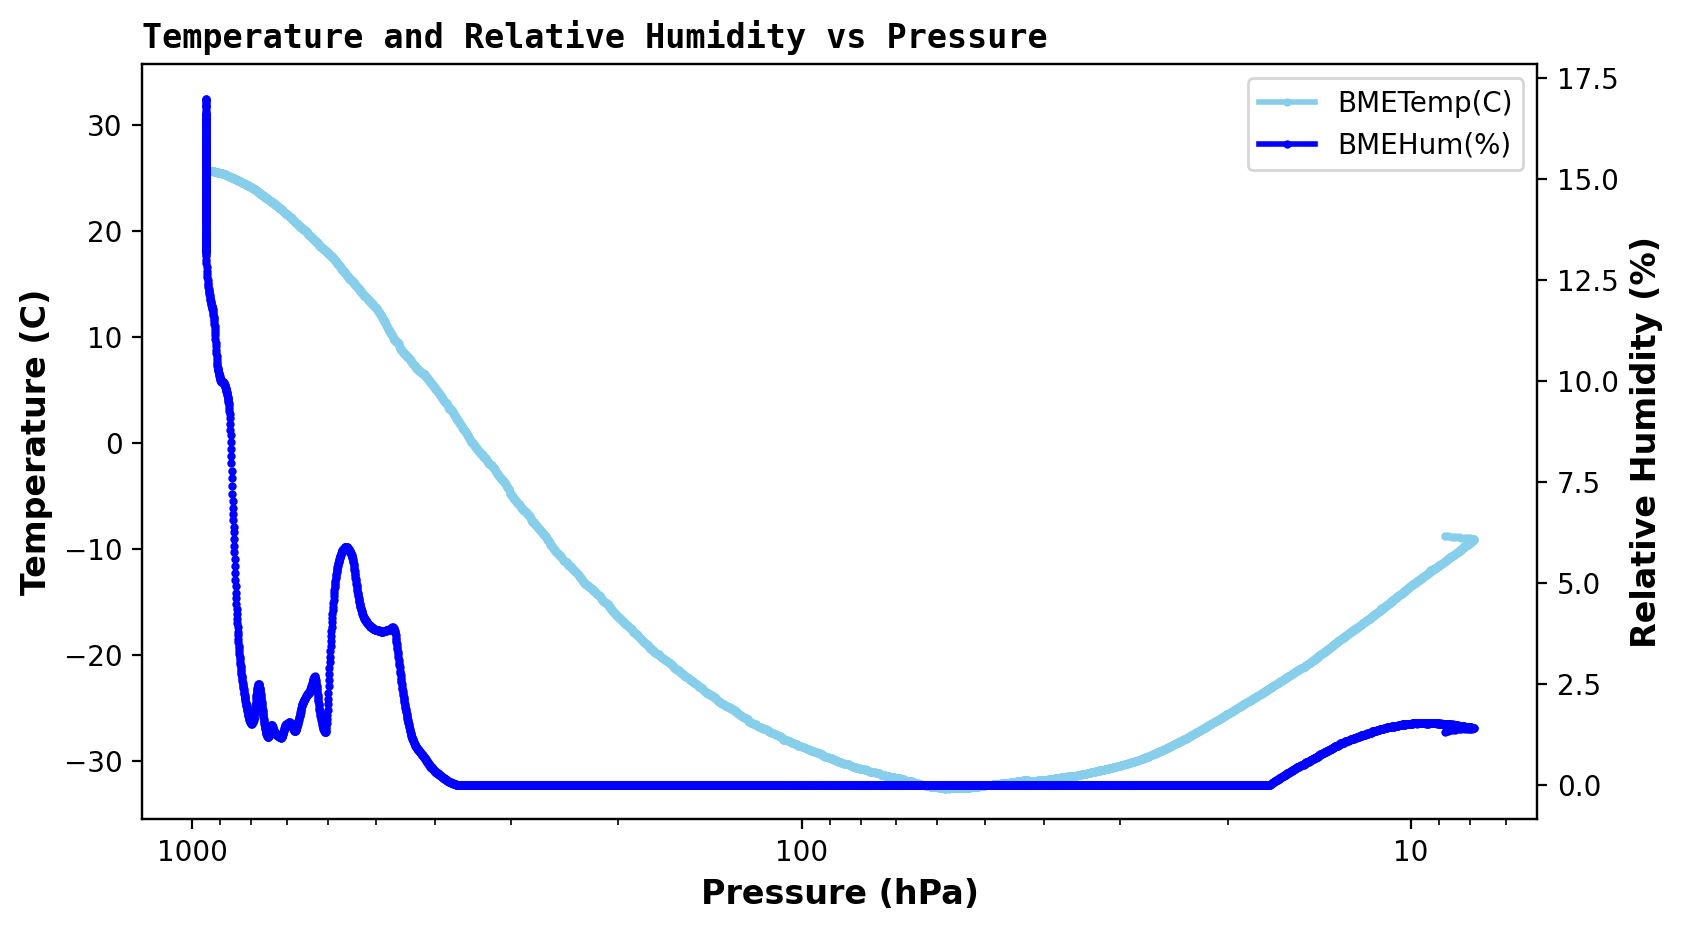

In [6]:
def pressurePlot(df, pressure_col, unit, var1, var2):
    fig, ax = plt.subplots(dpi=200)
    fig.set_figwidth(9)
    fig.set_figheight(5)
    
    plt.title(f"{var1[1]} and {var2[1]} vs Pressure", fontsize="large", loc="left", fontweight="bold", family="monospace")
    plt.xscale("log")
    
    ax.set_xlabel(f"Pressure ({unit})", fontsize="large", fontweight="bold")
    ax.set_ylabel(f"{var1[1]} ({var1[2]})", fontsize="large", fontweight="bold")
    line1 = plt.plot(pressure_col, var1[0], data=df, marker='o', markersize=2, color=var1[3], linewidth=2)    
    
    ax2 = ax.twinx()
    ax2.set_ylabel(f"{var2[1]} ({var2[2]})", fontsize="large", fontweight="bold")
    line2 = plt.plot(pressure_col, var2[0], data=df, marker='o', markersize=2, color=var2[3], linewidth=2)
    
    ax.set_ylim([None, ax.get_ylim()[1] * 1.25]);
    ax.invert_xaxis()
#     ax.xaxis.set_major_locator(plt.MaxNLocator(10))
    ax.xaxis.set_major_formatter(ScalarFormatter())
    ax.legend(line1 + line2, [line1[0].get_label(), line2[0].get_label()])
    
    plt.savefig(os.path.join(graph_folder, f"{'_'.join(f'{var1[1]} and {var2[1]}'.split())}_vs_pressure.svg"))
    plt.savefig(os.path.join(graph_folder, f"{'_'.join(f'{var1[1]} and {var2[1]}'.split())}_vs_pressure.png"))
    
    plt.show()

pressurePlot(flash_df, "BMEPress(hPa)", "hPa", ("BMETemp(C)", "Temperature", "C", "skyblue"), 
                                        ("BMEHum(%)", "Relative Humidity", "%", "blue"))


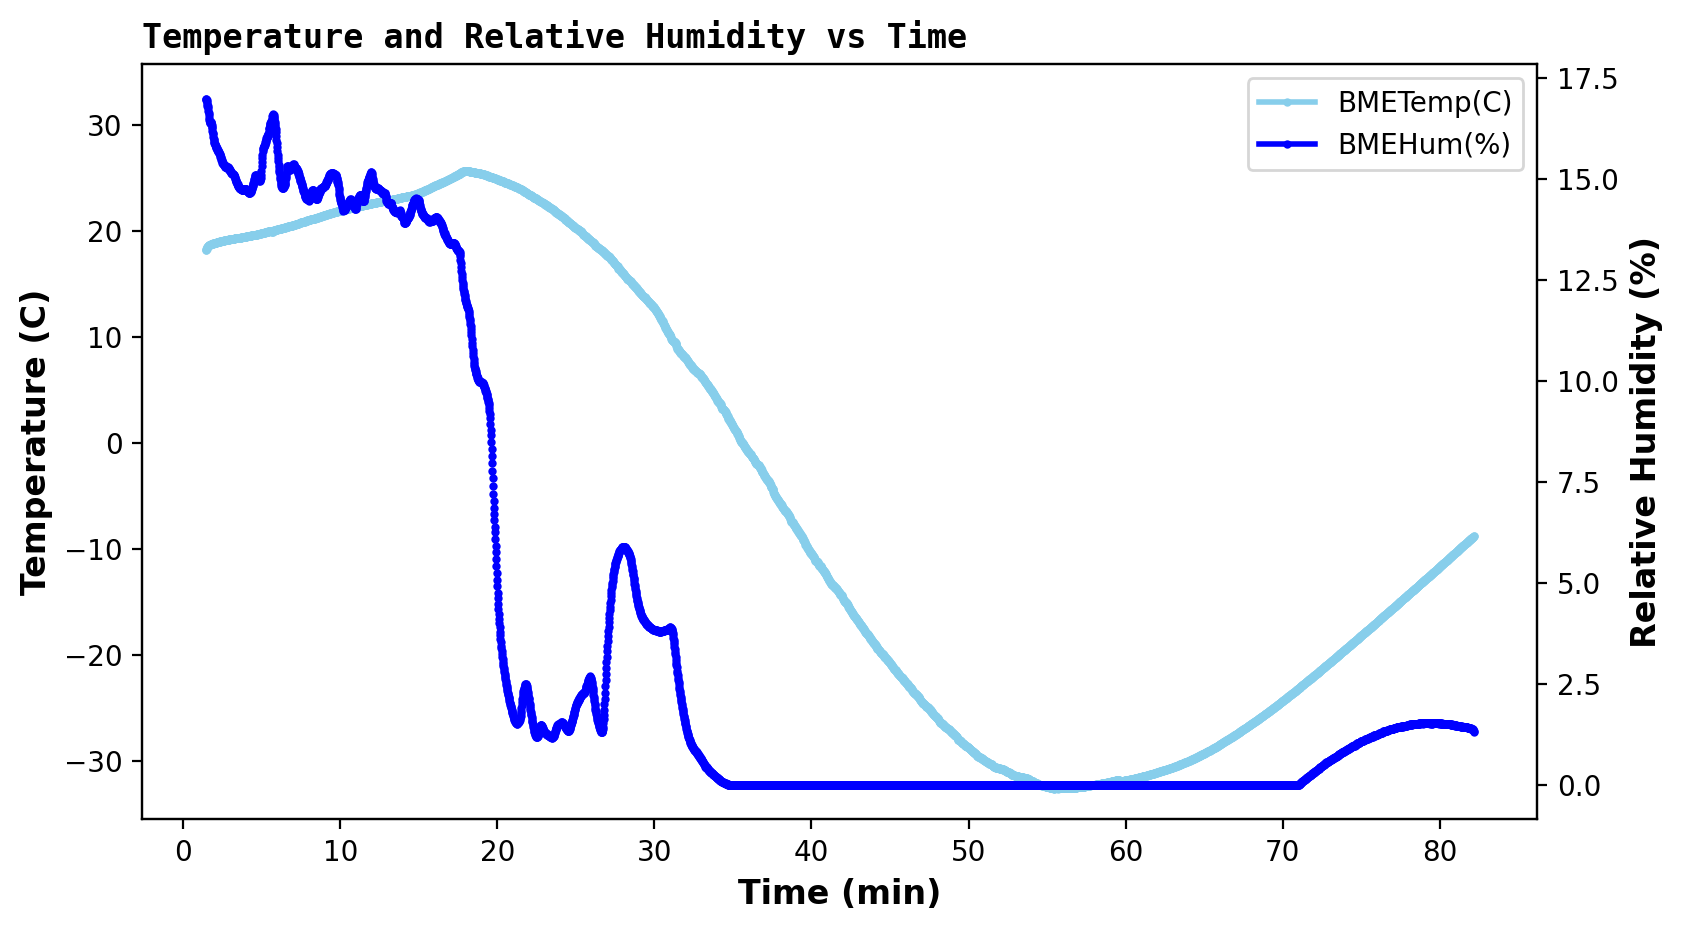

In [7]:
def timePlot(df, time_col, unit, var1, var2):
    fig, ax = plt.subplots(dpi=200)
    fig.set_figwidth(9)
    fig.set_figheight(5)
    
    plt.title(f"{var1[1]} and {var2[1]} vs Time", fontsize="large", loc="left", fontweight="bold", family="monospace")
    
    ax.set_xlabel(f"Time ({unit})", fontsize="large", fontweight="bold")
    ax.set_ylabel(f"{var1[1]} ({var1[2]})", fontsize="large", fontweight="bold")
    line1 = plt.plot(time_col, var1[0], data=df, marker='o', markersize=2, color=var1[3], linewidth=2)    
    
    ax2 = ax.twinx()
    ax2.set_ylabel(f"{var2[1]} ({var2[2]})", fontsize="large", fontweight="bold")
    line2 = plt.plot(time_col, var2[0], data=df, marker='o', markersize=2, color=var2[3], linewidth=2)
    
    ax.set_ylim([None, ax.get_ylim()[1] * 1.25]);
    ax.legend(line1 + line2, [line1[0].get_label(), line2[0].get_label()])
    
    plt.savefig(os.path.join(graph_folder, f"{'_'.join(f'{var1[1]} and {var2[1]}'.split())}_vs_time.svg"))
    plt.savefig(os.path.join(graph_folder, f"{'_'.join(f'{var1[1]} and {var2[1]}'.split())}_vs_time.png"))
    
    plt.show()

timePlot(flash_df, "Minutes(millis)", "min", ("BMETemp(C)", "Temperature", "C", "skyblue"), 
                                        ("BMEHum(%)", "Relative Humidity", "%", "blue"))
